In [126]:
import torch
from torch import nn
from torch import functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
import numpy as np

torch.__version__

'2.9.0+cu126'

In [127]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [128]:
!nvidia-smi

Tue Feb  3 14:47:10 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             30W /   70W |    4022MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [129]:
COLOR_CHANNELS = 3
IMG_SIZE = 32
PATCH_SIZE = 4
EMBEDDING_DIM = 768
BATCH_SIZE = 12
NUM_HEADS = 12
MLP_SIZE = 3072
TRANSFORMER_LAYER_NUM = 12
EMBEDDING_DROPOUT = 0.1
CLASSES_NUM=1000
PATCH_NUMBER = ( IMG_SIZE * IMG_SIZE ) // PATCH_SIZE ** 2

In [130]:
print(f"Patches number: {PATCH_NUMBER}")

Patches number: 64


In [131]:
class PatchEmbedding(nn.Module):
  """
  Turns a 2D input image into a 1D set of embedded patches.
  """
  def __init__(self,
               in_channels=COLOR_CHANNELS,
               patch_size=PATCH_SIZE,
               embedding_dim=EMBEDDING_DIM):
    """
    Arguments:
      - in_channels = Number of color channel for the input image. Default 3.
      - patch_size = Size of the patches to convert input image into. Default 16.
      - embedding_dim = Size of the embedding vector to turn image into. Default 768.
    """
    super().__init__()

    self.patch_size = patch_size

    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0) # No padding here

    self.flatter = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    # Prior size verification
    img_res = x.shape[-1]
    assert img_res % self.patch_size == 0, "Image resolution must be divisible by the patch size"

    x_patches = self.patcher(x)
    x_flattened = self.flatter(x_patches)
    x_embedded = x_flattened.permute(0, 2, 1)
    return x_embedded

In [132]:
# Test tensor (B, C, H, W)
input_tensor = torch.randn(BATCH_SIZE, COLOR_CHANNELS, IMG_SIZE, IMG_SIZE)
print(f"Input tensor shape : {input_tensor.shape}")

# Test PatchEmbedding class
Embedder = PatchEmbedding()
output_tensor = Embedder(input_tensor)
print(f"Output tensor shape : {output_tensor.shape}")

Input tensor shape : torch.Size([12, 3, 32, 32])
Output tensor shape : torch.Size([12, 64, 768])


In [133]:
class MultiHeadAttentionBlock(nn.Module):
  """
  Implements the multi head self attention block of the trasformer encoder.
  """
  def __init__(self,
                embedding_dim=EMBEDDING_DIM,
                num_heads=NUM_HEADS,
                attn_dropout:float=0):
    """
    Arguments:
      -embedding_dim: The constant latent vector size D used throughout the Transformer.
      -num_heads: Number of attention heads (k).
      -attn_dropout: Dropout probability applied to the attention weights.
    """
    super().__init__()

    self.normalizer = nn.LayerNorm(normalized_shape=embedding_dim)

    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 dropout=attn_dropout,
                                                 batch_first=True)

  def forward(self, x):
    x = self.normalizer(x)
    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x)
    return attn_output

In [134]:
class MLPBlock(nn.Module):
  """
  Implements the MLP block of the transformer encoder.
  """
  def __init__(self,
               embedding_dim=EMBEDDING_DIM,
               mlp_size=MLP_SIZE,
               mlp_dropout:float=0):
    super().__init__()

    self.normalizer = nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim, out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=mlp_dropout),
        nn.Linear(in_features=mlp_size, out_features=embedding_dim),
        nn.Dropout(p=mlp_dropout))

  def forward(self, x):
    x = self.normalizer(x)
    x = self.mlp(x)
    return x

In [135]:
class TransformerEncoder(nn.Module):
  """
  Create Transformer encoder block.
  """
  def __init__(self,
               embedding_dim=EMBEDDING_DIM,
               num_heads=NUM_HEADS,
               mlp_size=MLP_SIZE,
               attn_dropout:float=0,
               mlp_dropout:float=0):
    super().__init__()

    self.msa_block = MultiHeadAttentionBlock(embedding_dim=embedding_dim,
                              num_heads=num_heads)

    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size)

  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

In [136]:
class ViT(nn.Module):
  """
  Create Vision Transformer architecture model.
  """
  def __init__(self,
               img_size=IMG_SIZE, # Training resolution
               in_channels=COLOR_CHANNELS, # Number of color channels in input image
               patch_size=PATCH_SIZE, # Patch size
               transformer_layer_num=TRANSFORMER_LAYER_NUM, # Number of ViT layers from ViT paper table
               embedding_dim=EMBEDDING_DIM, # Hidden D size from ViT paper table
               mlp_size=MLP_SIZE, # MLP size from ViT paper table
               num_heads=NUM_HEADS, # Number of heads for MSA from ViT paper table
               attn_dropout:float=0, # Dropout for attention from ViT paper table
               mlp_dropout:float=0, # Dropout for MLP layers from ViT paper table
               embedding_dropout=EMBEDDING_DROPOUT, # Dropout for patch and positional embedding
               num_classes=CLASSES_NUM): # Number of classes to predict
    super().__init__()

    # Make sure the image size is divisible by the patch size
    assert img_size % patch_size == 0, "Image resolution must be divisible by the patch size"

    # Number of patches
    self.num_patches = (img_size * img_size) // patch_size ** 2

    # Create learnable class embedding
    self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim))

    # Create learnable positional embedding
    self.positional_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_dim))

    # Dropout value for patch and positional embedding
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # Create Transformer blocks
    self.transformer_layer = nn.Sequential(*[TransformerEncoder(embedding_dim=embedding_dim,
                                                                num_heads=num_heads,
                                                                mlp_size=mlp_size,
                                                                attn_dropout=attn_dropout,
                                                                mlp_dropout=mlp_dropout) for _ in range(transformer_layer_num)])

    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes))

  def forward(self, x):
     # Get batch size
     batch_size = x.shape[0]

     # Create class token embeddding and expand it to the batch size
     class_token = self.class_embedding.expand(batch_size, -1, -1)

     # Apply patch embedding
     x = self.patch_embedding(x)

     # Concatenate class embedding and patch embedding
     x = torch.cat((class_token, x), dim=1)

     # Add positional embedding
     x = x + self.positional_embedding

     # Apply dropout to embedding part
     x = self.embedding_dropout(x)

     # Pass patch, class and positional embedding through the tranformer blocks
     x = self.transformer_layer(x)

     # 0 logit for classifier
     x = self.classifier(x[:, 0])

     return x

In [137]:
# Instantiate model
model = ViT(img_size=IMG_SIZE, # Training resolution
            in_channels=COLOR_CHANNELS, # Number of color channels in input image
            patch_size=PATCH_SIZE, # Patch size
            transformer_layer_num=TRANSFORMER_LAYER_NUM, # Number of ViT layers from ViT paper table
            embedding_dim=EMBEDDING_DIM, # Hidden D size from ViT paper table
            mlp_size=MLP_SIZE, # MLP size from ViT paper table
            num_heads=NUM_HEADS, # Number of heads for MSA from ViT paper table
            embedding_dropout=EMBEDDING_DROPOUT, # Dropout for patch and positional embedding
            num_classes=CLASSES_NUM).to(device)

model

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(4, 4), stride=(4, 4))
    (flatter): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_layer): Sequential(
    (0): TransformerEncoder(
      (msa_block): MultiHeadAttentionBlock(
        (normalizer): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (normalizer): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0, inplace=False)
        )
      )
    )
    (1): TransformerE

In [138]:
!pip install torchmetrics
from torchmetrics import Accuracy

In [139]:
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

import time
import random
from tqdm.auto import tqdm

In [140]:
# Some transforms

basic_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [141]:
# Setting up data

# Setting up training data
train_data = datasets.CIFAR10(root="data", # Where to download data
                              train=True, # Get training data
                              transform=basic_transforms, # Image comes as a PIL format so we turn it into tensor
                              target_transform=None, # Transform labels
                              download=True,) # Download data if it doesn't exist on disk

# Setting up testing data
test_data = datasets.CIFAR10(root="data", # Where to download data
                             train=False, # Get testing data
                             transform=basic_transforms, # Image comes as a PIL format so we turn it into tensor
                             download=True) # Download data if it doesn't exist on disk

In [142]:
# Class names
class_names = train_data.classes
print(f"Class names : {class_names}")

Class names : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [143]:
# Turn train dataset into iterable batches
train_dataloader = DataLoader(dataset=train_data, # What data to turn into
                              batch_size=BATCH_SIZE, # Samples per batch
                              shuffle=True) # Shuffle training data every epoch

# Turn test dataset into iterable batches
test_dataloader = DataLoader(dataset=test_data, # What data to turn into
                             batch_size=BATCH_SIZE, # Samples per batch
                             shuffle=False) # No shuffle for testing data

In [144]:
print(f"Lenght of training dataloader : {len(train_dataloader)} of {BATCH_SIZE} samples")
print(f"Lenght of testing dataloader : {len(test_dataloader)} of {BATCH_SIZE} samples")

Lenght of training dataloader : 4167 of 12 samples
Lenght of testing dataloader : 834 of 12 samples


In [145]:
# Setup loss function(criterion), optimizer and accuracy function

# Cross Entropy loss function (we do classification not regression)
criterion = nn.CrossEntropyLoss()

# Stochastic Gradient Descent
optimizer = torch.optim.SGD(params=model.parameters(),
                lr=0.003)

# task="multiclass" and num_classes = classes number
accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

In [146]:
EPOCHS = 4

In [147]:
# Set seed
torch.manual_seed(42)

# Train start time on gpu
train_time_start_on_gpu = time.time()

train_acc_l, train_loss_l = [], []
test_acc_l, test_loss_l = [], []

for epoch in tqdm(range(EPOCHS)):
  print(f"----- Epoch: {epoch} -----")

  # Initialization
  train_loss, train_acc = 0, 0

  for batch , (X_train, y_train) in enumerate(train_dataloader): # (X, y) = (image(feature), label)
    # Set model on training mode
    model.train()

    # Set data on device
    X_train, y_train = X_train.to(device), y_train.to(device)

    # Foward pass
    y_train_pred = model(X_train)

    # Calculate the loss
    loss = criterion(y_train_pred, y_train)
    train_loss += loss

    # Calculate accuracy
    acc = accuracy_fn(y_train_pred.argmax(dim=1), y_train)
    train_acc += acc

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Print out how many samples have been seen
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X_train)}/{len(train_dataloader.dataset)} samples")

  # Train loss
  train_loss /= len(train_dataloader)
  train_loss_l.append(train_loss.item())

  # Train accuracy
  train_acc /= len(train_dataloader)
  train_acc_l.append(train_acc.item())

  # Initialization for testing
  test_loss, test_acc = 0, 0

  # Set model on evaluation mode
  model.eval()

  # Disables gradient tracking to save memory and speed up computation during testing
  with torch.inference_mode():
    for (X_test, y_test) in test_dataloader: # No need to keep track of batches here

      # Set data on device
      X_test, y_test = X_test.to(device), y_test.to(device)

      # Forward pass
      y_test_pred = model(X_test)

      # Calculate loss
      test_loss += criterion(y_test_pred, y_test)
      loss += test_loss

      # Calculate accuracy
      acc = accuracy_fn(y_test_pred.argmax(dim=1), y_test)
      test_acc += acc

    # Test loss
    test_loss /= len(test_dataloader)
    test_loss_l.append(test_loss.item())

    # Test accuracy
    test_acc /= len(test_dataloader)
    test_acc_l.append(test_acc.item())

  print(f" Train loss: {train_loss:.3f} | Test loss: {test_loss:.3f} ")
  print(f" Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f} ")

# Train end time on gpu
train_time_end_on_gpu = time.time()
total_time = train_time_end_on_gpu - train_time_start_on_gpu
print(f"Total training time on device {str(next(model.parameters()).device)}: {total_time:.3f} seconds")

  0%|          | 0/4 [00:00<?, ?it/s]

----- Epoch: 0 -----
Looked at 0/50000 samples
Looked at 4800/50000 samples
Looked at 9600/50000 samples
Looked at 14400/50000 samples
Looked at 19200/50000 samples
Looked at 24000/50000 samples
Looked at 28800/50000 samples
Looked at 33600/50000 samples
Looked at 38400/50000 samples
Looked at 43200/50000 samples
Looked at 48000/50000 samples
 Train loss: 2.094 | Test loss: 2.013 
 Train acc: 0.224 | Test acc: 0.283 
----- Epoch: 1 -----
Looked at 0/50000 samples
Looked at 4800/50000 samples
Looked at 9600/50000 samples
Looked at 14400/50000 samples
Looked at 19200/50000 samples
Looked at 24000/50000 samples
Looked at 28800/50000 samples
Looked at 33600/50000 samples
Looked at 38400/50000 samples
Looked at 43200/50000 samples
Looked at 48000/50000 samples
 Train loss: 1.894 | Test loss: 1.823 
 Train acc: 0.305 | Test acc: 0.343 
----- Epoch: 2 -----
Looked at 0/50000 samples
Looked at 4800/50000 samples
Looked at 9600/50000 samples
Looked at 14400/50000 samples
Looked at 19200/50000 s

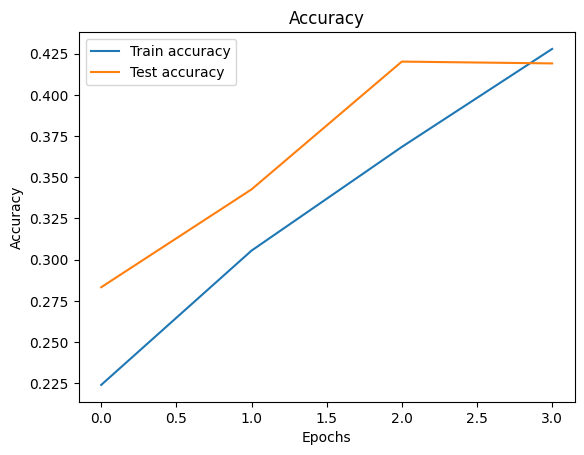

In [148]:
# Visualization
plt.figure()
plt.plot(train_acc_l, label="Train accuracy")
plt.plot(test_acc_l, label="Test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

In [155]:
def predict_and_plot(model: nn.Module,
                     dataset: torchvision.datasets,
                     classes :  list,
                     grid_size: int):
  # We want to predict so we put model in eval mode
  model.eval()

  fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(9, 9))
  for row in range(grid_size):
    for col in range(grid_size):
      idx = random.randint(0, len(dataset)-1)
      img, true_label = dataset[idx]
      input_tensor = img.unsqueeze(dim=0).to(device)
      with torch.inference_mode():
        output = model(input_tensor)
        predicted = output.argmax(dim=1).item()
        img = img / 2 + 0.5
        npimg = img.cpu().numpy()
        axes[row, col].imshow(npimg.transpose(1, 2, 0))
        truth = classes[true_label] == classes[predicted]
        if truth:
          color = 'g'
        else:
          color= 'r'

        axes[row, col].set_title(f"Truth: {classes[true_label]}\n Predicted: {classes[predicted]}", c=color)
        axes[row, col].axis(False)
  plt.show()

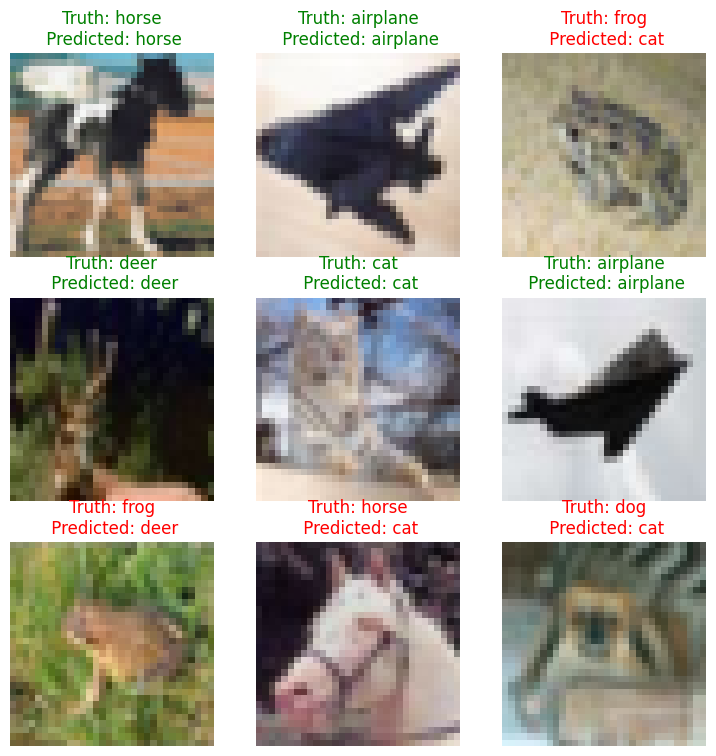

In [156]:
predict_and_plot(model=model,
                 dataset=test_data,
                 classes=class_names,
                 grid_size=3)